<a href="https://colab.research.google.com/github/mahapara2411/devopsgit/blob/main/CLV_BTYD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install lifetimes

     |████████████████████████████████| 584 kB 13.0 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.0f}'.format

In [4]:
from google.colab import files
uploaded = files.upload()

Saving online_retail_II.xlsx to online_retail_II.xlsx


In [5]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name = ["Year 2009-2010", "Year 2010-2011"]) #reading the excel file

In [6]:
df1 = df["Year 2009-2010"]
df2 = df["Year 2010-2011"]

In [7]:
df = df1.append(df2) #combining the data
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,"13,085",United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,"13,085",United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,"13,085",United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,"13,085",United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,"13,085",United Kingdom


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   CustomerID   824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


In [9]:
# any missing values?
dfgap = df[df.isnull().any(axis=1)]
dfgap

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,1,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,5,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,11,NaN,United Kingdom


In [10]:
dfgap.groupby("Invoice").nunique()

,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
Invoice,,,,,,,
489463,1,1,1,1,1,0,1
489464,1,1,1,1,1,0,1
489467,1,1,1,1,1,0,1
489521,1,0,1,1,1,0,1
489525,2,2,1,1,2,0,1
...,...,...,...,...,...,...,...
C578097,7,7,2,1,5,0,1
C579757,1,1,1,1,1,0,1
C579907,1,1,1,1,1,0,1


In [11]:
# delete rows in which we cannot identify the customer
df3 = df.copy()
df3 = df3[pd.notnull(df3["CustomerID"])]

In [12]:
# are any missing values left?
booMiss = df1.isnull().values.any()
if booMiss:
    _ = [print(k,":",v) for k,v in df1.isnull().sum().items() if v!=0]   # number missing

Description : 2928
CustomerID : 107927


In [13]:
# review the numerical values
df3.describe()

,Quantity,Price,CustomerID
count,"824,364","824,364","824,364"
mean,12,4,"15,325"
std,189,70,"1,697"
min,"-80,995",0,"12,346"
25%,2,1,"13,975"
50%,5,2,"15,255"
75%,12,4,"16,797"
max,"80,995","38,970","18,287"


In [14]:
# negative or zero quantities? => refunds, cancellations
df3[df3["Quantity"] <= 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,3,"16,321",Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,2,"16,321",Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4,"16,321",Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2,"16,321",Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,3,"16,321",Australia
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,1,"14,397",United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,225,"15,498",United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,11,"15,311",United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1,"17,315",United Kingdom


In [15]:
# restrict to transactions with positive quantities
df3 = df3[df3["Quantity"] > 0]

# datetime to date format
df3["InvoiceDate"] = pd.to_datetime(df3["InvoiceDate"]).dt.date #normalize()
#df1.set_index("InvoiceDate", inplace=False)

# treat CustomerID as a categorical variable
df3["CustomerID"] = df3["CustomerID"].astype(np.int64).astype(object)

# review the categorical variables
df3.describe(include='object').T

,count,unique,top,freq
Invoice,805620,36975,576339,542
StockCode,805620,4631,85123A,5188
Description,805620,5283,WHITE HANGING HEART T-LIGHT HOLDER,5181
InvoiceDate,805620,604,2010-12-05,5416
CustomerID,805620,5881,17841,12890
Country,805620,41,United Kingdom,725296


In [16]:
# delete columns that are not useful
try:
    d1 = df3.drop(["InvoiceNo", "StockCode", "Description", "Country"], axis=1, inplace=True)
except:
    pass
df3.describe(include='object').T

,count,unique,top,freq
Invoice,805620,36975,576339,542
StockCode,805620,4631,85123A,5188
Description,805620,5283,WHITE HANGING HEART T-LIGHT HOLDER,5181
InvoiceDate,805620,604,2010-12-05,5416
CustomerID,805620,5881,17841,12890
Country,805620,41,United Kingdom,725296


In [18]:
# revenues = quantity * unitprice
df3["Revenues"] = df3["Quantity"] * df3["Price"]
df3

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Revenues
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,7,13085,United Kingdom,83
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,7,13085,United Kingdom,81
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,7,13085,United Kingdom,81
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2,13085,United Kingdom,101
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1,13085,United Kingdom,30
...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2,12680,France,13
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4,12680,France,17
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4,12680,France,17
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09,5,12680,France,15


In [19]:
# review the numerical values
df3.describe()

,Quantity,Price,Revenues
count,"805,620","805,620","805,620"
mean,13,3,22
std,144,29,224
min,1,0,0
25%,2,1,5
50%,5,2,12
75%,12,4,20
max,"80,995","10,954","168,470"


In [20]:
df3.select_dtypes(exclude="object").sum()

Quantity   10,720,921
Price       2,583,042
Revenues   17,743,429
dtype: float64

In [21]:
# date structure
date_grp = df3.groupby(df3["InvoiceDate"]).mean()
date_grp

,Quantity,Price,Revenues
InvoiceDate,,,
2009-12-01,11,3,20
2009-12-02,13,3,23
2009-12-03,20,3,29
2009-12-04,10,3,18
2009-12-05,13,4,25
...,...,...,...
2011-12-05,11,3,17
2011-12-06,11,2,18
2011-12-07,19,3,32


**BG/NBD Model**

Train/Test Split

In [22]:
# train/test split (calibration/holdout)
t_holdout = 240                                         # days to reserve for holdout period

max_date = df3["InvoiceDate"].max()                     # end date of observations
print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
print("end of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = df3, 
        customer_id_col = "CustomerID", 
        datetime_col = "InvoiceDate",
        monetary_value_col = "Revenues", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date, 
        freq = "D")  

print("customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

end of observations: 2011-12-09
end of calibration period: 2011-04-13
customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,7,400,485,"11,067",0,0,240
12347,3,158,164,845,4,25,240
12348,3,190,198,496,1,103,240
12349,2,182,349,801,1,24,240
12350,0,0,70,0,0,0,240
...,...,...,...,...,...,...,...
18283,7,374,418,123,11,3,240
18284,0,0,191,0,0,0,240
18285,0,0,420,0,0,0,240


In [23]:
df_ch.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"4,777","4,777","4,777","4,777","4,777","4,777","4,777"
mean,3,169,320,275,2,20,240
std,7,169,144,448,4,95,0
min,0,0,0,0,0,0,240
25%,0,0,192,0,0,0,240
50%,1,130,352,195,1,6,240
75%,4,328,444,373,3,19,240
max,158,497,498,"11,067",96,"4,307",240


In [24]:
# training: frequency
pd.options.display.float_format = '{:,.3f}'.format
x = df_ch["frequency_cal"].value_counts(normalize=True)
x = x.nlargest(15)
print("frequency:")
x.sort_index(ascending=True)

frequency:


0.000    0.344
1.000    0.178
2.000    0.113
3.000    0.086
4.000    0.058
5.000    0.042
6.000    0.033
7.000    0.023
8.000    0.022
9.000    0.014
10.000   0.012
11.000   0.012
12.000   0.010
13.000   0.006
14.000   0.006
Name: frequency_cal, dtype: float64

In [25]:
# training: axis length
max_freq = df_ch["frequency_cal"].quantile(0.98)
max_rec = df_ch["recency_cal"].max()
max_T = df_ch["T_cal"].max()

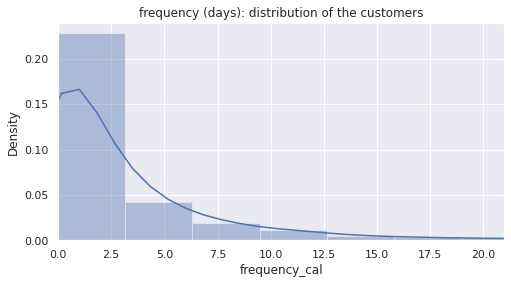

In [26]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["frequency_cal"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");

Text(0.5, 1.0, 'recency (days): distribution of the customers')

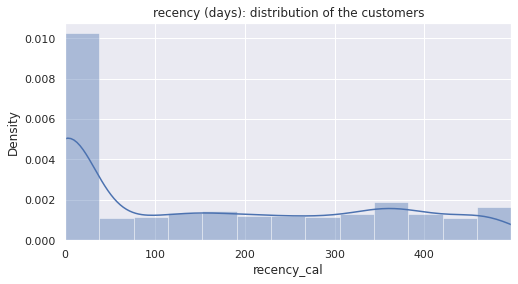

In [27]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["recency_cal"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers")

Text(0.5, 1.0, 'customer age T (days): distribution of the customers')

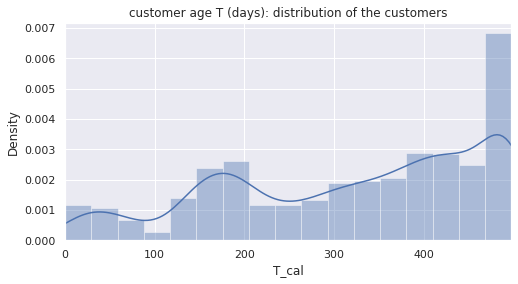

In [28]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["T_cal"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers")

**Fit the BG/NBD Model**

In [29]:
# training: BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)

Optimization terminated successfully.
         Current function value: -3.849697
         Iterations: 30
         Function evaluations: 31
         Gradient evaluations: 31


<lifetimes.BetaGeoFitter: fitted with 4777 subjects, a: 0.14, alpha: 67.80, b: 4.03, r: 0.70>

In [30]:
# training: summary
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.705,0.020,0.665,0.745
alpha,67.804,2.433,63.036,72.572
a,0.138,0.035,0.069,0.207
b,4.029,1.486,1.116,6.942


<Figure size 864x864 with 0 Axes>

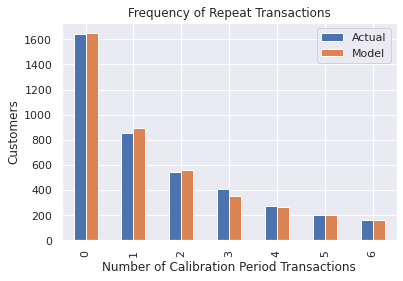

In [31]:
# training: does the model reflect the actual data closely enough?

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

<Figure size 504x504 with 0 Axes>

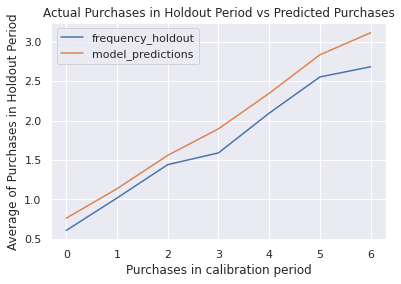

In [32]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch);

**Fitting Model to Full Dataset**

**Customer Recency, Frequency, Age T, Monetary Value (Revenues) for Each Customer**

In [34]:
# determine recency, frequency, T, monetary value for each customer
df_rft = summary_data_from_transaction_data(
    transactions = df3, 
    customer_id_col = "CustomerID", 
    datetime_col = "InvoiceDate", 
    monetary_value_col = "Revenues", 
    observation_period_end = max_date, 
    freq = "D")

pd.options.display.float_format = '{:,.0f}'.format
df_rft

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,7,400,725,"11,067"
12347,7,402,404,717
12348,4,363,438,449
12349,3,571,589,"1,120"
12350,0,0,310,0
...,...,...,...,...
18283,18,655,658,146
18284,0,0,431,0
18285,0,0,660,0


In [35]:
df_rft.describe()

,frequency,recency,T,monetary_value
count,"5,881","5,881","5,881","5,881"
mean,5,273,474,319
std,10,259,223,"2,256"
min,0,0,0,0
25%,0,0,313,0
50%,2,220,530,213
75%,5,512,668,376
max,254,738,738,"168,470"


**Fitting the BG/NBD Model**

In [36]:
# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -6.934800
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.663,0.016,0.632,0.694
alpha,63.184,1.935,59.392,66.976
a,0.108,0.015,0.078,0.139
b,2.411,0.521,1.389,3.432


In [37]:
#axis length
max_freq = int(df_rft["frequency"].max())  #quantile(0.95))          
max_T = int(df_rft["T"].max())                         
max_rec = int(df_rft["recency"].max())  
print(max_freq)

254


<Figure size 864x864 with 0 Axes>

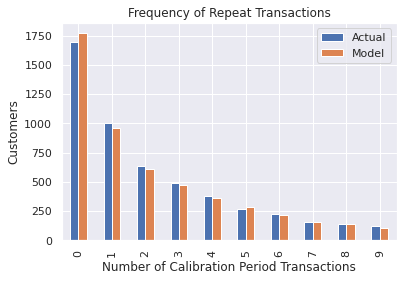

In [38]:
# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,  
            max_frequency = 10);

**Predictions**

In [39]:
# helper function: plot expected number of future purchases a customer with 
#    frequency f and recency r will make in forecast period

def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7)) 
    plot_frequency_recency_matrix(
            model = bgf,   
            T = t,  
            max_frequency = max_freq,  
            max_recency = max_rec);

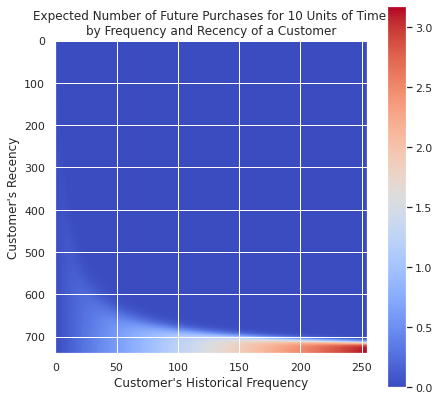

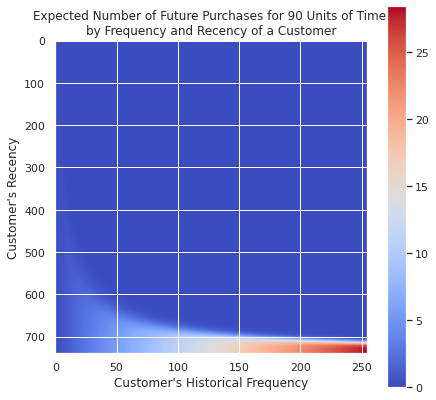

In [40]:
# call plotter function for different forecast periods:
tFC = [10, 90]
_ = [plot_freq_rec(t) for t in tFC]

In [41]:
# predict purchases for a selected customer for t days
t = 30
custID = 12748

df_rft_C = df_rft.loc[custID,:]
predC = bgf.predict(    t, 
                        df_rft_C["frequency"], 
                        df_rft_C["recency"], 
                        df_rft_C["T"])
print("customer", custID, ": expected number of purchases within", t, "days =", f'{predC:.1f}')

customer 12748 : expected number of purchases within 30 days = 7.6


In [42]:
# selected customer: transactions
df1C = df1[df1["CustomerID"] == custID]
df1C.describe()

,Quantity,Price,CustomerID
count,"2,665.000","2,665.000","2,665.000"
mean,4.826,4.016,"12,748.000"
std,12.280,28.189,0.000
min,-243.000,0.000,"12,748.000"
25%,1.000,0.850,"12,748.000"
50%,2.000,1.650,"12,748.000"
75%,4.000,2.950,"12,748.000"
max,243.000,800.000,"12,748.000"


373


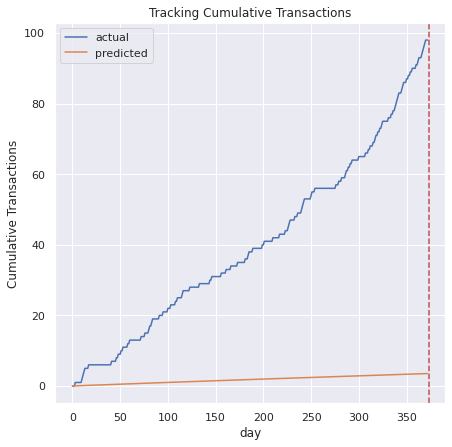

In [43]:
# X selected customer: cumulative transactions
max_date = df1["InvoiceDate"].max()
min_date = df1["InvoiceDate"].min()
span_days = (max_date - min_date).days
print(span_days)

fig = plt.figure(figsize=(7, 7)) 
plot_cumulative_transactions(
            model = bgf,  
            transactions = df1C, 
            datetime_col = "InvoiceDate",  
            customer_id_col = "CustomerID",  
            t = span_days,  
            t_cal = span_days);

In [44]:
# helper function: predict each customer's purchases over next t days
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])

In [45]:
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [10, 30, 60, 90]
_ = [predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rft

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
CustomerID,,,,,,,,
12346,7.0,400.0,725.0,"11,066.6",0.1,0.2,0.3,0.5
12347,7.0,402.0,404.0,717.4,0.2,0.5,1.0,1.4
12348,4.0,363.0,438.0,449.3,0.1,0.3,0.5,0.8
12349,3.0,571.0,589.0,"1,120.1",0.1,0.2,0.3,0.5
12350,0.0,0.0,310.0,0.0,0.0,0.1,0.1,0.2
...,...,...,...,...,...,...,...,...
18283,18.0,655.0,658.0,146.4,0.3,0.8,1.5,2.3
18284,0.0,0.0,431.0,0.0,0.0,0.0,0.1,0.1
18285,0.0,0.0,660.0,0.0,0.0,0.0,0.1,0.1


In [46]:
# top 10 customers over next 30 days
print("top 10 customers, by their predicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
CustomerID,,,,,,,,
14911,254.0,737.0,738.0,"1,162.4",3.2,9.5,19.0,28.4
12748,202.0,735.0,735.0,279.1,2.5,7.6,15.2,22.7
15311,195.0,738.0,738.0,594.6,2.4,7.3,14.6,21.8
17841,192.0,736.0,737.0,366.4,2.4,7.2,14.4,21.5
14606,180.0,735.0,736.0,170.3,2.3,6.8,13.5,20.2
13089,131.0,735.0,737.0,888.3,1.6,4.9,9.8,14.7
14527,120.0,735.0,737.0,223.9,1.5,4.5,9.0,13.5
14156,120.0,729.0,738.0,"2,607.3",1.5,4.5,9.0,13.4
12971,98.0,721.0,724.0,162.4,1.3,3.7,7.5,11.2


In [47]:
# recency, frequency, T
dfx = df1[df1["CustomerID"] == 14527]
xmax_date = dfx["InvoiceDate"].max()
xmin_date = dfx["InvoiceDate"].min()

# recency:
print("customer minimum date:", xmin_date)
print("customer maximum date:", xmax_date)
xrec = (xmax_date - xmin_date).days
print("recency:", xrec)                                    # recency = time span between first and last purchase

# age T:
xmaxall_date = df1["InvoiceDate"].max()
print("population maximum date:", xmaxall_date)
xage = (xmaxall_date - xmin_date).days                    # age T
print("T:", xage)

# frequency:
xfreq = len(dfx[dfx["Quantity"] > 0].groupby("InvoiceDate"))-1    # frequency: periods with repeat purchases
print("frequency:", xfreq)

customer minimum date: 2009-12-02 12:06:00
customer maximum date: 2010-12-09 12:32:00
recency: 372
population maximum date: 2010-12-09 20:01:00
T: 372
frequency: 69


predicted average number of customer purchases over next 90 days:


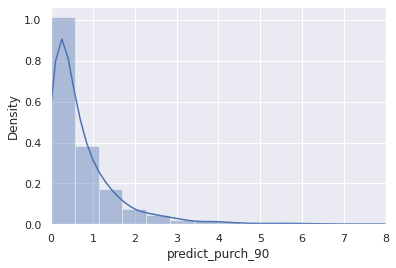

In [48]:
print("predicted average number of customer purchases over next 90 days:")
ax = sns.distplot(df_rft["predict_purch_90"]).set_xlim(0,8)

In [49]:
# helper function: probability of n repeat purchases within t days
def prob_purch(t, n):
    p = bgf.probability_of_n_purchases_up_to_time(t, n)
    return p

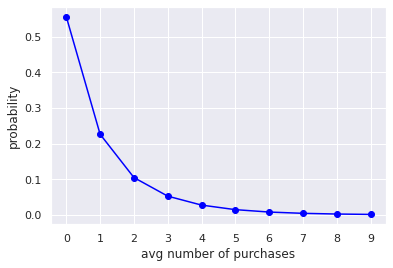

In [50]:
# call helper function: probability of n repeat purchases within t days
t = 90                  # forecast period, days
purch = range(0,10,1)   # number of repeat purchases 
probs = [prob_purch(t,n) for n in purch]

dict_probs = dict(zip(purch, probs))
#_ = [print(k,":",f'{v:.2f}') for k,v in dict_probs.items()]

plt.plot(purch, probs, '-o', color='blue')
plt.xlabel("avg number of purchases")
plt.ylabel("probability")
plt.xticks(purch)
plt.show()

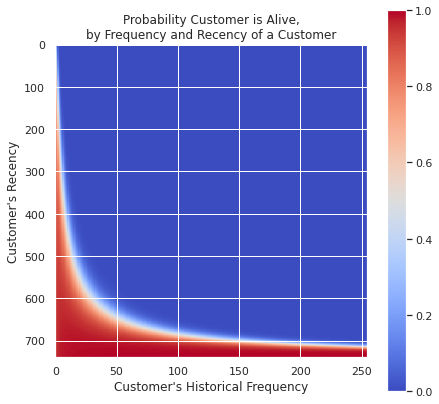

In [51]:
# probability that a customer has not churned (= is alive), based on 
# customer's specific recency r and frequency f
fig = plt.figure(figsize=(7, 7)) 
plot_probability_alive_matrix(
            model = bgf,  
            max_frequency = max_freq,  
            max_recency = max_rec);

In [52]:
# probability that a customer is alive for each customer in dataframe
prob_alive = bgf.conditional_probability_alive(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"])

df_rft["prob_alive"] = prob_alive
pd.options.display.float_format = '{:,.2f}'.format
df_rft.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
count,"5,881.00","5,881.00","5,881.00","5,881.00","5,881.00","5,881.00","5,881.00","5,881.00","5,881.00"
mean,4.63,273.25,474.25,318.88,0.09,0.27,0.53,0.79,0.91
std,10.00,258.97,223.14,"2,256.28",0.14,0.41,0.81,1.21,0.17
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,313.00,0.00,0.02,0.06,0.12,0.18,0.93
50%,2.00,220.00,530.00,213.47,0.05,0.15,0.31,0.46,0.98
75%,5.00,512.00,668.00,376.09,0.11,0.32,0.65,0.97,1.00
max,254.00,738.00,738.00,"168,469.60",3.17,9.51,18.99,28.42,1.00


In [53]:
# show customers who are alive, but with less than 90% certainty
df_rft[df_rft["prob_alive"] < 0.9]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
CustomerID,,,,,,,,,
12346,7.00,400.00,725.00,"11,066.64",0.06,0.17,0.33,0.50,0.57
12353,1.00,204.00,408.00,89.00,0.03,0.09,0.19,0.28,0.90
12361,3.00,395.00,682.00,134.02,0.04,0.13,0.26,0.38,0.87
12369,2.00,228.00,641.00,721.41,0.03,0.08,0.17,0.25,0.75
12373,2.00,362.00,673.00,344.88,0.03,0.10,0.19,0.28,0.88
...,...,...,...,...,...,...,...,...,...
18260,21.00,552.00,724.00,459.70,0.14,0.41,0.82,1.23,0.50
18271,1.00,122.00,731.00,488.30,0.01,0.04,0.08,0.12,0.66
18275,1.00,153.00,731.00,369.21,0.02,0.05,0.09,0.13,0.72


In [54]:
# pick a customer
custID = 14527
df_rft[df_rft.index == custID]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
CustomerID,,,,,,,,,
14527,120.00,735.00,737.00,223.90,1.51,4.51,9.00,13.48,1.00


In [55]:
# select a customer

custID = 15107

df1C = df1[df1["CustomerID"] == custID]
df1C.describe()

,Quantity,Price,CustomerID
count,33.00,33.00,33.00
mean,5.61,6.05,"15,107.00"
std,6.76,3.96,0.00
min,-1.00,0.85,"15,107.00"
25%,2.00,2.95,"15,107.00"
50%,4.00,5.45,"15,107.00"
75%,6.00,8.50,"15,107.00"
max,36.00,14.95,"15,107.00"


customer 15107 : probability of being alive over time


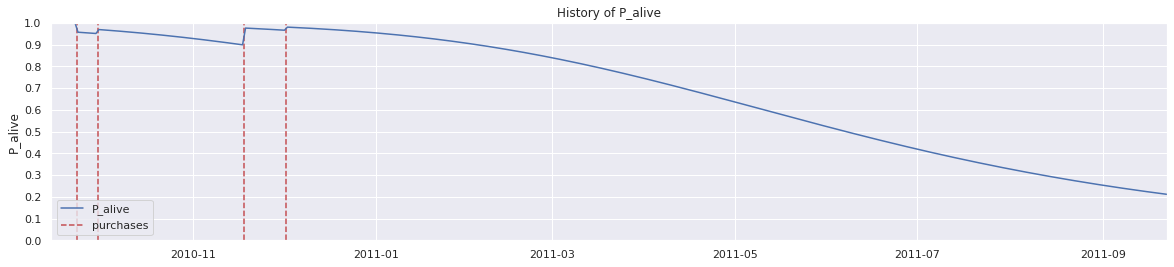

In [56]:
# history of the selected customer: probability over time of being alive
fig = plt.figure(figsize=(20,4))
print("customer",custID,": probability of being alive over time")
plot_history_alive(
                    model = bgf, 
                    t = span_days, 
                    transactions = df1C, 
                    datetime_col = "InvoiceDate");

In [57]:
# selected customer's probability of being alive - development over time
path_alive = calculate_alive_path(
            model = bgf, 
            t = span_days, 
            transactions = df1C, 
            datetime_col = "InvoiceDate");
print("customer",custID,"'s probability of being alive, development over time")
path_alive.explode().astype(np.float64).describe()

customer 15107 's probability of being alive, development over time


count   374.00
mean      0.70
std       0.26
min       0.21
25%       0.45
50%       0.78
75%       0.94
max       1.00
dtype: float64

**Customer Lifetime Value: The Gamma-Gamma Model**

**Fitting the Gamma-Gamma Model**

In [58]:
# select customers with monetary value > 0
df_rftv = df_rft[df_rft["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
count,"4,189.00","4,189.00","4,189.00","4,189.00","4,189.00","4,189.00","4,189.00","4,189.00","4,189.00"
mean,6.50,383.63,522.11,447.69,0.11,0.34,0.68,1.02,0.88
std,11.33,227.62,202.96,"2,662.68",0.15,0.46,0.91,1.36,0.19
min,1.00,1.00,9.00,3.90,0.00,0.00,0.00,0.00,0.00
25%,2.00,176.00,408.00,191.65,0.04,0.11,0.21,0.32,0.88
50%,3.00,387.00,589.00,306.37,0.07,0.22,0.44,0.66,0.96
75%,7.00,592.00,688.00,452.72,0.14,0.42,0.85,1.26,0.98
max,254.00,738.00,738.00,"168,469.60",3.17,9.51,18.99,28.42,1.00


In [59]:
# Gamma-Gamma model requires a Pearson correlation close to 0 
# between purchase frequency and monetary value

corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.023


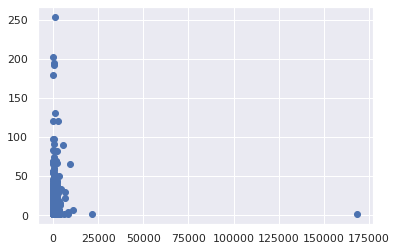

In [60]:
dfx = df_rftv["monetary_value"]
dfy = df_rftv["frequency"]
plt.scatter(dfx, dfy)

In [61]:
# outlier
df_rftv[df_rftv["monetary_value"] == df_rftv["monetary_value"].max()]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
CustomerID,,,,,,,,,
16446,1.00,205.00,205.00,"168,469.60",0.06,0.18,0.35,0.53,0.96


In [62]:
# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 1e-06)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,4.811,0.204,4.412,5.211
q,2.537,0.059,2.422,2.653
v,136.687,7.002,122.963,150.411


**Predictions**

In [63]:
# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rftv["frequency"],
        df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]

mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

MAPE of predicted revenues: 0.10


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
CustomerID,,,,,,,,,,,,
12346,7.000,400.000,725.000,"11,066.637",0.055,0.166,0.331,0.495,0.569,"10,602.190","11,066.637",-464.447
12347,7.000,402.000,404.000,717.399,0.162,0.484,0.965,1.444,0.987,704.754,717.399,-12.644
12348,4.000,363.000,438.000,449.310,0.089,0.267,0.532,0.797,0.959,447.716,449.310,-1.594
12349,3.000,571.000,589.000,"1,120.057",0.055,0.164,0.327,0.489,0.973,"1,053.416","1,120.057",-66.640
12352,8.000,356.000,392.000,338.261,0.186,0.556,1.109,1.658,0.977,341.699,338.261,3.438


In [64]:
# compute customer lifetime value
DISCOUNT_a = 0.06                # annual discount rate
LIFE = 12                        # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = df_rftv["frequency"],  
        recency = df_rftv["recency"],  
        T = df_rftv["T"],  
        monetary_value = df_rftv["monetary_value"],  
        time = LIFE,    
        freq = "D",                          
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)             # expected customer lifetime values
df_rftv.describe().T

,count,mean,std,min,25%,50%,75%,max
CLV,"4,189.000","2,019.832","8,657.199",0.000,344.016,785.212,"1,785.014","259,630.604"
frequency,"4,189.000",6.501,11.326,1.000,2.000,3.000,7.000,254.000
recency,"4,189.000",383.626,227.619,1.000,176.000,387.000,592.000,738.000
T,"4,189.000",522.114,202.964,9.000,408.000,589.000,688.000,738.000
monetary_value,"4,189.000",447.686,"2,662.683",3.900,191.650,306.366,452.715,"168,469.600"
predict_purch_10,"4,189.000",0.115,0.153,0.000,0.035,0.074,0.142,3.175
predict_purch_30,"4,189.000",0.343,0.457,0.000,0.106,0.221,0.424,9.511
predict_purch_60,"4,189.000",0.683,0.912,0.000,0.211,0.441,0.846,18.985
predict_purch_90,"4,189.000",1.022,1.365,0.000,0.316,0.660,1.263,28.424
prob_alive,"4,189.000",0.878,0.188,0.000,0.878,0.955,0.979,0.999


In [65]:
df_rftv.sort_values(by="CLV", ascending=False)

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
CustomerID,,,,,,,,,,,,,
18102,"259,630.604",66.000,738.000,738.000,"9,189.930",0.830,2.487,4.965,7.433,0.998,"9,147.713","9,189.930",-42.218
16446,"253,777.163",1.000,205.000,205.000,"168,469.600",0.059,0.177,0.353,0.527,0.957,"127,776.648","168,469.600","-40,692.952"
14646,"223,851.417",90.000,736.000,737.000,"5,809.905",1.131,3.388,6.762,10.125,0.999,"5,790.864","5,809.905",-19.041
17450,"141,087.010",30.000,430.000,438.000,"6,924.523",0.608,1.819,3.628,5.426,0.994,"6,856.053","6,924.523",-68.470
14156,"133,384.032",120.000,729.000,738.000,"2,607.330",1.500,4.493,8.970,13.429,0.997,"2,601.541","2,607.330",-5.788
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15633,0.548,12.000,222.000,731.000,346.714,0.000,0.000,0.000,0.000,0.000,348.816,346.714,2.102
14590,0.159,18.000,308.000,732.000,161.012,0.000,0.000,0.000,0.000,0.000,165.665,161.012,4.653
13093,0.139,42.000,460.000,735.000,"1,284.528",0.000,0.000,0.000,0.000,0.000,"1,278.059","1,284.528",-6.469


**Parameter Distributions**

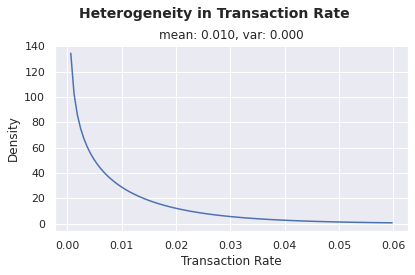

In [66]:
# Gamma distribution of lambda: customers' propensitiy to purchase
plot_transaction_rate_heterogeneity(model = bgf)   

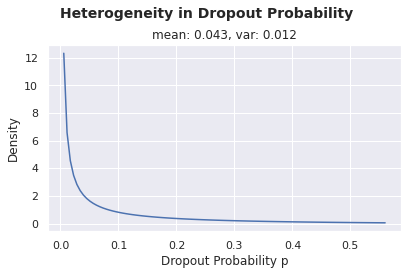

In [67]:
# Beta distribution of p: customer's probability of dropping out immediately after a transaction
plot_dropout_rate_heterogeneity(model = bgf)